In [1]:
import glob
import os
import pandas as pd
import numpy as np
from dbfread import DBF
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
from scipy.stats import yeojohnson
from sklearn.metrics import r2_score
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Import data

In [2]:
# Direct path to the specific shapefile
shp_file = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'

# para guardar os csvs futuramente
processed_folder = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior'

# Verify it exists
if not os.path.exists(shp_file):
    raise FileNotFoundError(f"File not found: {shp_file}")

print(f"Importing {shp_file}...")

# Load shapefile into a GeoDataFrame
df_name = os.path.splitext(os.path.basename(shp_file))[0]
dataframes = {df_name: gpd.read_file(shp_file)}

Importing ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp...


In [3]:
cols = [
    "inidoy","enddoy","ros_p","1_3y_fir_p","3_8y_fir_p","8_ny_fir_p","elev_av","aspect_av",
    "landform","fuel_model","f_load_av","land_use","CBH_m_av","HigCC_p_av","LowCC_p_av",
    "MidCC_p_av","TotCC_p_av","BLH_m_av","Cape_av","Cin_av","gp_m2s2_av","t_2m_C_av",
    "d_2m_C_av","sP_hPa_av","wv10_kh_av","wdir10_av","wv100_k_av","wdir100_av","rh_2m_av",
    "VPD_Pa_av","dfmc_av","sW_1m_av","sW_3m_av","LCL_hPa_av","LCL_m_av","HDW_av",
    "Haines_av","wSv_9_av","wSdir_9_av","wSv_7_av","wSdir_7_av","wSv_5_av","wSdir_5_av",
    "wSv_1_av","wSdir_1_av","gT_s_9_av","gT_9_8_av","gT_8_7_av","gT_7_5_av","gT_5_3_av",
    "CMLG_av","LFC_hPa_av","CCL_hPa_av","EL_m_av","VentIdx_av","LiftIdx_av","gp_950_av",
    "gp_850_av","gp_700_av","gp_500_av","gp_300_av","rh_950_av","rh_850_av","rh_700_av",
    "rh_500_av","rh_300_av","t_950_av","t_850_av","t_700_av","t_500_av","t_300_av",
    "vwv_950_av","vwv_850_av","vwv_700_av","vwv_500_av","vwv_300_av","wv_950_av",
    "wv_850_av","wv_700_av","wv_500_av","wv_300_av","wdi_950_av","wdi_850_av","wdi_700_av",
    "wdi_500_av","wdi_300_av","wv_10_av","wdi_10_av","wv_100_av","wdi_100_av","BLH_m_rt",
    "Recirc","CircVar","CircStd_dg","ros_p_lg1","ros_p_lg2","ros_p_lg3","ros_p_lg4",
    "ros_p_lg5","ros_p_lg6","ros_p_lg7","ros_p_lg8","ros_p_lg9","ros_p_lg10","duration"
]

for name, df in dataframes.items():
    valid_cols = [c for c in cols if c in df.columns]
    df[valid_cols] = df[valid_cols].replace([-1, -999], np.nan)
    dataframes[name] = df

### log transformation

In [4]:
#log transformation

cols_log = [
    "ros_p","1_3y_fir_p","3_8y_fir_p","8_ny_fir_p","elev_av",
    "f_load_av","CBH_m_av","HigCC_p_av","LowCC_p_av",
    "MidCC_p_av","TotCC_p_av","BLH_m_av","Cape_av","Cin_av","gp_m2s2_av","t_2m_C_av",
    "d_2m_C_av","sP_hPa_av","wv10_kh_av","wdir10_av","wv100_k_av","wdir100_av","rh_2m_av",
    "VPD_Pa_av","dfmc_av","sW_1m_av","sW_3m_av","LCL_hPa_av","LCL_m_av","HDW_av",
    "wSv_9_av","wSdir_9_av","wSv_7_av","wSdir_7_av","wSv_5_av","wSdir_5_av",
    "wSv_1_av","wSdir_1_av","gT_s_9_av","gT_9_8_av","gT_8_7_av","gT_7_5_av","gT_5_3_av",
    "CMLG_av","LFC_hPa_av","CCL_hPa_av","EL_m_av","VentIdx_av","LiftIdx_av","gp_950_av",
    "gp_850_av","gp_700_av","gp_500_av","gp_300_av","rh_950_av","rh_850_av","rh_700_av",
    "rh_500_av","rh_300_av","t_950_av","t_850_av","t_700_av","t_500_av","t_300_av",
    "vwv_950_av","vwv_850_av","vwv_700_av","vwv_500_av","vwv_300_av","wv_950_av",
    "wv_850_av","wv_700_av","wv_500_av","wv_300_av","wdi_950_av","wdi_850_av","wdi_700_av",
    "wdi_500_av","wdi_300_av","wv_10_av","wdi_10_av","wv_100_av","wdi_100_av","BLH_m_rt",
    "Recirc","CircVar","CircStd_dg","ros_p_lg1","ros_p_lg2","ros_p_lg3","ros_p_lg4",
    "ros_p_lg5","ros_p_lg6","ros_p_lg7","ros_p_lg8","ros_p_lg9","ros_p_lg10","duration"
]

base = os.path.splitext(os.path.basename(shp_file))[0]
print(f"Importing {base}...")

# Carregar shapefile completo
gdf = gpd.read_file(shp_file)

# Selecionar apenas colunas da lista que existam no GDF
valid_cols = [c for c in cols_log if c in gdf.columns]

# Substituir valores inválidos antes do log
gdf[valid_cols] = gdf[valid_cols].replace([-1, -999, 0], np.nan)

# Aplicar log natural APENAS às colunas selecionadas
gdf[valid_cols] = np.log(gdf[valid_cols])

# Guardar com sufixo _log
output_path = os.path.join(processed_folder, f"{base}_log.shp")
print(f"Saving {output_path}...")
gdf.to_file(output_path)

print("All files processed.")

Importing PT-FireProg_v2.1_L2_model...
Saving ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model_log.shp...
All files processed.


/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


### sqrt transformation

In [5]:
# Square root transformation
cols_sqrt = [
    "ros_p","1_3y_fir_p","3_8y_fir_p","8_ny_fir_p","elev_av",
    "f_load_av","CBH_m_av","HigCC_p_av","LowCC_p_av",
    "MidCC_p_av","TotCC_p_av","BLH_m_av","Cape_av","Cin_av","gp_m2s2_av","t_2m_C_av",
    "d_2m_C_av","sP_hPa_av","wv10_kh_av","wdir10_av","wv100_k_av","wdir100_av","rh_2m_av",
    "VPD_Pa_av","dfmc_av","sW_1m_av","sW_3m_av","LCL_hPa_av","LCL_m_av","HDW_av",
    "wSv_9_av","wSdir_9_av","wSv_7_av","wSdir_7_av","wSv_5_av","wSdir_5_av",
    "wSv_1_av","wSdir_1_av","gT_s_9_av","gT_9_8_av","gT_8_7_av","gT_7_5_av","gT_5_3_av",
    "CMLG_av","LFC_hPa_av","CCL_hPa_av","EL_m_av","VentIdx_av","LiftIdx_av","gp_950_av",
    "gp_850_av","gp_700_av","gp_500_av","gp_300_av","rh_950_av","rh_850_av","rh_700_av",
    "rh_500_av","rh_300_av","t_950_av","t_850_av","t_700_av","t_500_av","t_300_av",
    "vwv_950_av","vwv_850_av","vwv_700_av","vwv_500_av","vwv_300_av","wv_950_av",
    "wv_850_av","wv_700_av","wv_500_av","wv_300_av","wdi_950_av","wdi_850_av","wdi_700_av",
    "wdi_500_av","wdi_300_av","wv_10_av","wdi_10_av","wv_100_av","wdi_100_av","BLH_m_rt",
    "Recirc","CircVar","CircStd_dg","ros_p_lg1","ros_p_lg2","ros_p_lg3","ros_p_lg4",
    "ros_p_lg5","ros_p_lg6","ros_p_lg7","ros_p_lg8","ros_p_lg9","ros_p_lg10","duration"
]

base = os.path.splitext(os.path.basename(shp_file))[0]
print(f"Importing {base}...")

# Load complete shapefile
gdf = gpd.read_file(shp_file)

# Select only columns from the list that exist in the GDF
valid_cols = [c for c in cols_sqrt if c in gdf.columns]

# Replace invalid values before sqrt
gdf[valid_cols] = gdf[valid_cols].replace([-1, -999], np.nan)

# Replace negative values with NaN (sqrt of negative numbers is not defined)
gdf[valid_cols] = gdf[valid_cols].apply(lambda x: x.where(x >= 0, np.nan))

# Apply square root only to selected columns
gdf[valid_cols] = np.sqrt(gdf[valid_cols])

# Save with _sqrt suffix
output_path = os.path.join(processed_folder, f"{base}_sqrt.shp")
print(f"Saving {output_path}...")
gdf.to_file(output_path)

print("All files processed.")

Importing PT-FireProg_v2.1_L2_model...
Saving ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model_sqrt.shp...
All files processed.


### Plot ROS_P Distribution


Analyzing PT-FireProg_v2.1_L2_model...


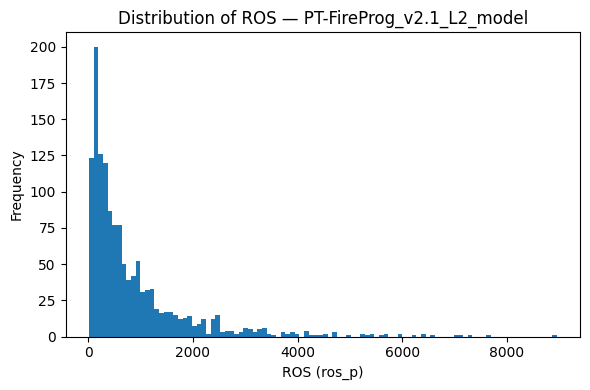

D’Agostino–Pearson Normality Test for ros_p
Statistic: 859.3369
p-value: 2.4967e-187
Reject H₀ (data is likely not normal).


In [7]:
for name, df in dataframes.items():
    print(f"\nAnalyzing {name}...")

    if "ros_p" not in df.columns:
        print("Skipped — 'ros_p' column not found.")
        continue

    # Convert ros_p to numeric and drop NaNs
    ros_data = pd.to_numeric(df["ros_p"], errors="coerce").dropna()

    if len(ros_data) == 0:
        print("Skipped — no valid 'ros_p' values.")
        continue

    # Plot histogram
    plt.figure(figsize=(6, 4))
    plt.hist(ros_data, bins=100)
    plt.title(f"Distribution of ROS — {name}")
    plt.xlabel("ROS (ros_p)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Perform D’Agostino–Pearson normality test
    stat, p_value = stats.normaltest(ros_data)

    print("D’Agostino–Pearson Normality Test for ros_p")
    print(f"Statistic: {stat:.4f}")
    print(f"p-value: {p_value:.4e}")

    if p_value > 0.05:
        print("Fail to reject H₀ (data appears normal).")
    else:
        print("Reject H₀ (data is likely not normal).")

### Compute descriptive statistics (mean, median, quartiles, std, skewness, kurtosis)

In [8]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

def _to_numeric_series(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors='coerce')

# ========== DEFINE CATEGORICAL VARIABLES HERE ==========
categorical_variables = [
    'Haines_av',
    'burn_perio',
    'land_use',
    'zp_link',
    'year',
    "fuel_model",
    "landform"
    # Add your categorical variable names here
]
# =======================================================

# Dictionary to hold statistics for each file
all_stats = {}

for name, df in dataframes.items():
    print(f"Processing descriptive statistics for {name}...")

    # Convert object columns that contain numeric data
    for col in df.columns:
        if df[col].dtype == 'object' and col not in categorical_variables:
            converted = pd.to_numeric(df[col], errors='coerce')
            if not converted.isna().all():
                df[col] = converted
    
    # Identify categorical columns that exist in this dataframe
    categorical_cols = [col for col in categorical_variables if col in df.columns]
    
    # Select numeric columns only (exclude 'sdate' and categorical variables)
    numeric_cols = df.select_dtypes(include=['number']).columns.difference(['sdate'] + categorical_cols)
    
    all_cols = list(numeric_cols) + categorical_cols
    
    if len(all_cols) == 0:
        print(f"No valid columns found in {name}. Skipping.")
        continue
    
    # Create stats dataframe with all columns
    desc_stats = pd.DataFrame(index=all_cols)
    
    # ========== NUMERIC VARIABLES ==========
    if len(numeric_cols) > 0:
        desc_stats.loc[numeric_cols, 'mean'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).mean())
        desc_stats.loc[numeric_cols, 'median'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).median())
        desc_stats.loc[numeric_cols, 'std'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).std())
        desc_stats.loc[numeric_cols, 'var'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).var())
        desc_stats.loc[numeric_cols, 'q05'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.05))
        desc_stats.loc[numeric_cols, 'q25'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.25))
        desc_stats.loc[numeric_cols, 'q75'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.75))
        desc_stats.loc[numeric_cols, 'q95'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.95))
        desc_stats.loc[numeric_cols, 'min'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).min())
        desc_stats.loc[numeric_cols, 'max'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).max())
        desc_stats.loc[numeric_cols, 'skewness'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).skew())
        desc_stats.loc[numeric_cols, 'kurtosis'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).kurtosis())
        desc_stats.loc[numeric_cols, 'n_missing'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).isna().sum())
        desc_stats.loc[numeric_cols, 'pct_missing'] = df[numeric_cols].apply(lambda col: (_to_numeric_series(col).isna().sum() / len(col)) * 100)
        desc_stats.loc[numeric_cols, 'n_zeros'] = df[numeric_cols].apply(lambda col: (_to_numeric_series(col) == 0).sum())
        desc_stats.loc[numeric_cols, 'n_negative'] = df[numeric_cols].apply(lambda col: (_to_numeric_series(col) < 0).sum())
        desc_stats.loc[numeric_cols, 'AIQ'] = desc_stats.loc[numeric_cols, 'q75'] - desc_stats.loc[numeric_cols, 'q25']
        
        # D'Agostino-Pearson normality test
        for col in numeric_cols:
            col_series = _to_numeric_series(df[col])
            valid_data = col_series.dropna()
            if len(valid_data) >= 8:  # D'Agostino test requires at least 8 observations
                try:
                    _, p_value = stats.normaltest(valid_data)
                    desc_stats.loc[col, 'normality_p'] = p_value
                except Exception as e:
                    print(f"Normality test failed for {col}: {e}")
                    desc_stats.loc[col, 'normality_p'] = np.nan
            else:
                desc_stats.loc[col, 'normality_p'] = np.nan
    
    # ========== CATEGORICAL VARIABLES ==========
    if len(categorical_cols) > 0:
        for col in categorical_cols:
            desc_stats.loc[col, 'n_unique'] = df[col].nunique()
            desc_stats.loc[col, 'mode'] = df[col].mode()[0] if len(df[col].mode()) > 0 else np.nan
            desc_stats.loc[col, 'mode_freq'] = df[col].value_counts().iloc[0] if len(df[col].value_counts()) > 0 else np.nan
            desc_stats.loc[col, 'mode_pct'] = (desc_stats.loc[col, 'mode_freq'] / len(df)) * 100 if pd.notna(desc_stats.loc[col, 'mode_freq']) else np.nan
            desc_stats.loc[col, 'n_missing'] = df[col].isna().sum()
            desc_stats.loc[col, 'pct_missing'] = (df[col].isna().sum() / len(df)) * 100
    
    # ========== R² and Correlation with ros_p ==========
    if 'ros_p' in df.columns:
        ros_series = pd.to_numeric(df['ros_p'], errors='coerce')
        ros_series = ros_series.replace([np.inf, -np.inf], np.nan)
        
        # For numeric variables: Pearson correlation
        for col in numeric_cols:
            if col != 'ros_p':
                col_series = pd.to_numeric(df[col], errors='coerce')
                valid_idx = ros_series.notna() & col_series.notna()
                if valid_idx.sum() > 1:
                    corr = ros_series[valid_idx].corr(col_series[valid_idx])
                    desc_stats.loc[col, 'corr_ros_p'] = corr
                    desc_stats.loc[col, 'R2_ros_p'] = corr ** 2
                else:
                    desc_stats.loc[col, 'corr_ros_p'] = np.nan
                    desc_stats.loc[col, 'R2_ros_p'] = np.nan
        
        # For categorical variables: Eta-squared (effect size from ANOVA)
        for col in categorical_cols:
            try:
                valid_idx = ros_series.notna() & df[col].notna()
                if valid_idx.sum() > 1:
                    groups = df.loc[valid_idx, col]
                    values = ros_series[valid_idx]
                    
                    # Need at least 2 groups
                    if groups.nunique() < 2:
                        desc_stats.loc[col, 'corr_ros_p'] = np.nan
                        desc_stats.loc[col, 'R2_ros_p'] = np.nan
                        continue
                    
                    # Calculate eta-squared (proportion of variance explained)
                    group_means = values.groupby(groups).mean()
                    overall_mean = values.mean()
                    
                    ss_between = sum(values.groupby(groups).size() * (group_means - overall_mean) ** 2)
                    ss_total = sum((values - overall_mean) ** 2)
                    
                    if ss_total > 0:
                        eta_squared = ss_between / ss_total
                        # Correlation coefficient is the square root of eta-squared
                        # Use eta as the "correlation-like" measure for categorical variables
                        desc_stats.loc[col, 'corr_ros_p'] = np.sqrt(eta_squared)
                        desc_stats.loc[col, 'R2_ros_p'] = eta_squared
                    else:
                        desc_stats.loc[col, 'corr_ros_p'] = np.nan
                        desc_stats.loc[col, 'R2_ros_p'] = np.nan
                else:
                    desc_stats.loc[col, 'corr_ros_p'] = np.nan
                    desc_stats.loc[col, 'R2_ros_p'] = np.nan
            except Exception as e:
                print(f"R² calculation failed for categorical {col}: {e}")
                desc_stats.loc[col, 'corr_ros_p'] = np.nan
                desc_stats.loc[col, 'R2_ros_p'] = np.nan
    else:
        desc_stats['corr_ros_p'] = np.nan
        desc_stats['R2_ros_p'] = np.nan
    
    # ========== VIF calculation ==========
    if 'ros_p' in df.columns:
        for col in all_cols:
            if col != 'ros_p' and col in desc_stats.index:
                r2 = desc_stats.loc[col, 'R2_ros_p']
                if pd.notna(r2) and r2 < 1.0:
                    desc_stats.loc[col, 'VIF'] = 1.0 / (1.0 - r2)
                else:
                    desc_stats.loc[col, 'VIF'] = np.nan
        
        # Set ros_p VIF to NaN
        if 'ros_p' in desc_stats.index:
            desc_stats.loc['ros_p', 'VIF'] = np.nan
    else:
        print(f"'ros_p' not found in {name}")
        desc_stats['VIF'] = np.nan
    
    # Add variable type column
    desc_stats['var_type'] = 'numeric'
    desc_stats.loc[categorical_cols, 'var_type'] = 'categorical'
    
    # Final column ordering
    numeric_stat_cols = ['mean', 'median', 'std', 'var', 'q05', 'q25', 'q75', 'q95', 'min', 'max', 'AIQ', 
                         'skewness', 'kurtosis', 'n_zeros', 'n_negative', 'normality_p']
    categorical_stat_cols = ['n_unique', 'mode', 'mode_freq', 'mode_pct']
    common_cols = ['n_missing', 'pct_missing', 'corr_ros_p', 'R2_ros_p', 'VIF', 'var_type']
    
    final_cols = numeric_stat_cols + categorical_stat_cols + common_cols
    desc_stats = desc_stats[[col for col in final_cols if col in desc_stats.columns]]
    
    desc_stats.loc['sdate'] = np.nan
    
    all_stats[name] = desc_stats
    
    # Save to CSV
    path = Path("../../Data/Data_Exploration")
    path.mkdir(parents=True, exist_ok=True)
    output_path = path / f'descriptive_stats_{name}.csv'
    desc_stats.to_csv(output_path)
    print(f"Saved {output_path}")

print("All descriptive statistics have been generated and saved.")

Processing descriptive statistics for PT-FireProg_v2.1_L2_model...
Saved ../../Data/Data_Exploration/descriptive_stats_PT-FireProg_v2.1_L2_model.csv
All descriptive statistics have been generated and saved.


## Fazer plots dashboard

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from ipywidgets import widgets, VBox, HBox, Layout
from IPython.display import display, clear_output

# Carregar DataFrame transformado
df_transformed = dataframes["PT-FireProg_v2.1_L2_model_log"]

# Selecionar apenas colunas numéricas
numeric_df = df_transformed.select_dtypes(include=[np.number])
if numeric_df.empty:
    raise ValueError("No numeric columns found in the DataFrame.")

# Preparar dados brutos
original_data = {}
for col in numeric_df.columns:
    data = numeric_df[col].replace([np.inf, -np.inf], np.nan).dropna()
    if len(data) > 0:
        original_data[col] = data.values

# Widgets
checkboxes = {
    col: widgets.Checkbox(value=False, description=col, indent=False)
    for col in original_data.keys()
}
select_all_btn = widgets.Button(description="Select All", button_style='info', icon='check')
deselect_all_btn = widgets.Button(description="Deselect All", button_style='warning', icon='times')
output = widgets.Output()

# Funções
def update_plot(*args):
    with output:
        clear_output(wait=True)
        selected = [col for col, cb in checkboxes.items() if cb.value]
        if not selected:
            print("No features selected. Please select at least one feature.")
            return
        
        n_cols = 2
        n_rows = int(np.ceil(len(selected) / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
        axes = axes.flatten()
        
        for i, col in enumerate(selected):
            data = original_data[col]
            kde = stats.gaussian_kde(data)
            x = np.linspace(data.min(), data.max(), 2000)
            axes[i].plot(x, kde(x), lw=2, color='blue')
            axes[i].set_title(col)
            axes[i].set_xlabel('Value')
            axes[i].set_ylabel('Density')
            axes[i].grid(True, linestyle='--', alpha=0.5)  # adiciona gridlines
        
        # Remover eixos extras
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])
        
        plt.tight_layout()
        plt.show()

def select_all(_):
    for cb in checkboxes.values():
        cb.value = True

def deselect_all(_):
    for cb in checkboxes.values():
        cb.value = False

# Bind eventos
for cb in checkboxes.values():
    cb.observe(update_plot, names='value')
select_all_btn.on_click(select_all)
deselect_all_btn.on_click(deselect_all)

# Layout
checkbox_container = VBox(
    list(checkboxes.values()),
    layout=Layout(
        height='250px',
        overflow_y='auto',
        border='1px solid #ccc',
        padding='10px'
    )
)

controls = VBox([
    widgets.HTML("<h3>Select Features to Plot Density Lines:</h3>"),
    HBox([select_all_btn, deselect_all_btn]),
    widgets.HTML("<b>Variables (scrollable):</b>"),
    checkbox_container
])

ui = VBox([controls, output])

# Exibir UI
display(ui)
update_plot()

KeyError: 'PT-FireProg_v2.1_L2_model_log'